# Movinet Streaming Model Tutorial

This tutorial trains a [MoViNet](https://arxiv.org/abs/2103.11511) with `A0` configuration from the TensorFlow Model Garden package (tensorflow-models).

[Model Garden](https://www.tensorflow.org/tfmodels) contains a collection of state-of-the-art models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

**Streaming Models**:

Streaming models implement causal (2+1)D convolutions with stream buffers. Streaming models use (2+1)D convolution instead of 3D to utilize optimized tf.nn.conv2d operations, which offer fast inference on CPU. Streaming models can be run on individual frames or on larger video clips like base models.

**Note**: A3, A4, and A5 models use a positional encoding in the squeeze-excitation blocks, while A0, A1, and A2 do not. For the smaller models, accuracy is unaffected without positional encoding, while for the larger models accuracy is significantly worse without positional encoding.

**Dataset:** [UCF_101](https://www.tensorflow.org/datasets/catalog/ucf101)
* A 101-label video classification dataset

**This tutorial demonstrates how to:**

* Use models from the TensorFlow Models package.
* Train/Fine-tune a pre-built [MoViNet](https://arxiv.org/abs/2103.11511) for Video Classification.
* Export the trained/tuned MoViNet-A0-Stream model

## Install Necessary libraries

In [ ]:
%pip install --upgrade pip
%pip install -q "tf-models-official"

# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
%pip install mediapy remotezip
%pip install git+https://github.com/tensorflow/docs

In [3]:
%pip install -q imageio numpy seaborn ipywidgets
!wget https://storage.googleapis.com/thumos14_files/UCF101_videos.zip

  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Import necessary libraries

In [3]:
import os
import tqdm
import random
import pathlib
import imageio
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from tensorflow_docs.vis import embed

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorboard


In [2]:
%load_ext tensorboard

## Import the MoViNet model from TensorFlow Models (tf-models-official)

In [4]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

## Download Subdataset of UCF_101

In [5]:
# @title Helper functions for loading data and visualizing
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=200, loop=0)
  return embed.embed_file('./animation.gif')


class FrameGenerator:
  def __init__(self, path: pathlib.PosixPath, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label
num_classes = None

In [4]:
# Helper functions below used are taken from following tutorials
# https://www.tensorflow.org/tutorials/video/video_classification
# https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet

# URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
URL = pathlib.Path(os.path.join(os.path.abspath(''), 'UCF101_videos.zip'))
!rm -r ./UCF101_subset
download_dir = pathlib.Path('./UCF101_subset/')
num_classes = 101
subset_paths = download_ufc_101_subset(URL,
                        num_classes = num_classes,
                        splits = {"train1": 30, "val": 10, "test": 50},
                        download_dir = download_dir)

train1 :


100%|██████████| 3030/3030 [00:32<00:00, 92.96it/s] 


val :


100%|██████████| 1010/1010 [00:04<00:00, 233.12it/s]


test :


100%|██████████| 2620/2620 [00:34<00:00, 76.30it/s] 


## Prepare train, valid and test dataset

In [6]:
batch_size = 4
num_frames = 8
if num_classes == None:
    num_classes = 101
CLASSES = sorted(os.listdir('./UCF101_subset/train1'))
print(CLASSES)
# print(subset_paths)
subset_paths = {'train1': pathlib.PosixPath('UCF101_subset/train1/'), 'train2': pathlib.PosixPath('UCF101_subset/train2/'), 'train3': pathlib.PosixPath('UCF101_subset/train3/'), 'val': pathlib.PosixPath('UCF101_subset/val/'), 'test': pathlib.PosixPath('UCF101_subset/test/')}
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train1_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train1'], num_frames, training = True),
                                          output_signature = output_signature)
train1_ds = train1_ds.batch(batch_size)
# train2_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train2'], num_frames, training = True),
#                                           output_signature = output_signature)
# train2_ds = train2_ds.batch(batch_size)
# train3_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train3'], num_frames, training = True),
#                                           output_signature = output_signature)
# train3_ds = train3_ds.batch(batch_size)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                          output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

2023-10-27 00:12:51.934165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 00:12:52.156644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 00:12:52.156900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 00:12:52.160412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 00:12:52.160867: I tensorflow/compile

In [7]:
fg = FrameGenerator(subset_paths['train1'], num_frames, training = True)
label_names = list(fg.class_ids_for_name)
fg2 = FrameGenerator(subset_paths['test'], num_frames)
label_names_t = list(fg2.class_ids_for_name)
fg3= FrameGenerator(subset_paths['val'], num_frames)
label_names_v = list(fg3.class_ids_for_name)
print(len(label_names), len(label_names_t), len(label_names_v))

101 101 101


### Check the prepared training batch of the data

In [8]:
for frames, labels in train1_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

Shape: (4, 8, 172, 172, 3)
Label: (4,)


## Build the model

### Construct the backbone with proper parameters

In [9]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Construct the model

In [22]:
# Note: this is a temporary model constructed for the
# purpose of loading the pre-trained checkpoint. Only
# the backbone will be used to build the custom classifier.

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

### Load the pretrained weights

In [22]:
# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


### Set up the distribution strategy

In [10]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct custom classifier with required number of classes

In [11]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, num_frames, resolution, backbone, num_classes)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  optimizer = tf.keras.optimizers.AdamW()
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

### Load previous trained checkpoint (optional)

In [12]:
checkpoint_dir = 'trained_model/cp.ckpt'
model.load_weights(checkpoint_dir)
# checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint = tf.train.Checkpoint(model=model)
# status = checkpoint.restore(checkpoint_path)
# status.assert_existing_objects_matched()

## Create a callback for storing the checkpoints

In [21]:
# model.summary(line_length=200)
tf.lite.experimental.Analyzer.analyze(model_path="tflite_models/model.tflite.int8", gpu_compatibility=False)

=== tflite_models/model.tflite.int8 ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the RESHAPE op takes
tensor #37 and tensor #44 as input and produces tensor #322 as output.

Subgraph#0 main(T#0, T#1, T#2, T#3, T#4, T#5, T#6, T#7, T#8, T#9, T#10, T#11, T#12, T#13, T#14, T#15, T#16, T#17, T#18, T#19, T#20, T#21, T#22, T#23, T#24, T#25, T#26, T#27, T#28, T#29, T#30, T#31, T#32, T#33, T#34, T#35, T#36, T#37, T#38, T#39, T#40, T#41, T#42, T#43) -> [T#776, T#438, T#478, T#623, T#671, T#695, T#747, T#863, T#622, T#586, T#872, T#527, T#550, T#658, T#735, T#734, T#415, T#659, T#337, T#338, T#367, T#599, T#551, T#479, T#806, T#403, T#694, T#772, T#402, T#635, T#835, T#379, T#587, T#514, T#563, T#861, T#775, T#439, T#451, T#491, T#836, T#805, T#707, T#515]
  Op#0 RESHAPE(T#37, T#44[1, 172, 172, 3]) -> [T#322]
  Op#1 CONV_2D(T#322, T#321, T#320[18335, 30423, 12643, 83155, -46153, ...]) -> [T#323]
  Op#2

: 

In [14]:
checkpoint_path = "trained_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 
                                                 verbose=1)

tb_callback = keras.callbacks.TensorBoard(log_dir='logs/fit/')

## Train the model

In [15]:
results = model.fit(train1_ds,
                    validation_data=val_ds,
                    epochs=1,
                    validation_freq=1,
                    verbose=1,
                    
                    callbacks=[cp_callback, tb_callback])

2023-10-27 00:15:44.412036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-27 00:15:52.119500: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f495d2732e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-27 00:15:52.119549: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-10-27 00:15:52.251297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-27 00:15:52.841321: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    758/Unknown - 1066s 1s/step - loss: 0.9940 - accuracy: 0.8175
Epoch 1: val_loss improved from inf to 0.87756, saving model to trained_model/cp.ckpt
758/758 [==============================] - 1157s 1s/step - loss: 0.9940 - accuracy: 0.8175 - val_loss: 0.8776 - val_accuracy: 0.8525


In [21]:
results = model.fit(train1_ds,
                    validation_data=val_ds,
                    epochs=5,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/5


    758/Unknown - 814s 1s/step - loss: 0.1837 - accuracy: 0.9492
Epoch 1: saving model to trained_model/cp.ckpt
758/758 [==============================] - 937s 1s/step - loss: 0.1837 - accuracy: 0.9492 - val_loss: 1.8717 - val_accuracy: 0.7307
Epoch 2/5
758/758 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9396
Epoch 2: saving model to trained_model/cp.ckpt
758/758 [==============================] - 903s 1s/step - loss: 0.1982 - accuracy: 0.9396 - val_loss: 2.4305 - val_accuracy: 0.7129
Epoch 3/5
758/758 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9469
Epoch 3: saving model to trained_model/cp.ckpt
758/758 [==============================] - 1007s 1s/step - loss: 0.1903 - accuracy: 0.9469 - val_loss: 1.9587 - val_accuracy: 0.7406
Epoch 4/5
758/758 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9389
Epoch 4: saving model to trained_model/cp.ckpt
758/758 [==============================] - 898s 1s/step - loss: 0

In [23]:
results = model.fit(train1_ds,
                    validation_data=val_ds,
                    epochs=1,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback])

    758/Unknown - 954s 1s/step - loss: 0.1626 - accuracy: 0.9571
Epoch 1: saving model to trained_model/cp.ckpt
758/758 [==============================] - 1122s 1s/step - loss: 0.1626 - accuracy: 0.9571 - val_loss: 2.1169 - val_accuracy: 0.7525


## Evaluate the model

In [26]:
model.evaluate(val_ds)

2023-09-14 01:12:44.013776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


253/253 [==============================] - 114s 396ms/step - loss: 1.2941 - accuracy: 0.8634


[1.2941296100616455, 0.8633663654327393]

In [31]:
model.evaluate(test_ds)

655/655 [==============================] - 596s 910ms/step - loss: 1.1538 - accuracy: 0.8492


[1.1538208723068237, 0.8492366671562195]

In [16]:
model = tf.keras.models.load_model('model')

ValueError: Received incompatible tensor with shape (1, 1, 368, 96) when attempting to restore variable with shape (1, 1, 184, 48) and name block2_layer0/bneck/se/se_reduce/conv2d/conv2d_1/kernel:0.

## Plot the test data confusion matrix

In [27]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [28]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(len(labels), len(labels))})
  sns.set(font_scale=1.0)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

In [51]:
test2_path = pathlib.PosixPath('UCF101_subset/test2/')
test2_ds = tf.data.Dataset.from_generator(FrameGenerator(test2_path, num_frames),
                                         output_signature = output_signature)
test2_ds = test2_ds.batch(batch_size)

fg3 = FrameGenerator(test2_path, num_frames)
label_names_test = list(fg3.class_ids_for_name.keys())

In [29]:
%matplotlib inline
actual, predicted = get_actual_predicted_labels(test_ds)


655/655 [==============================] - 261s 391ms/step


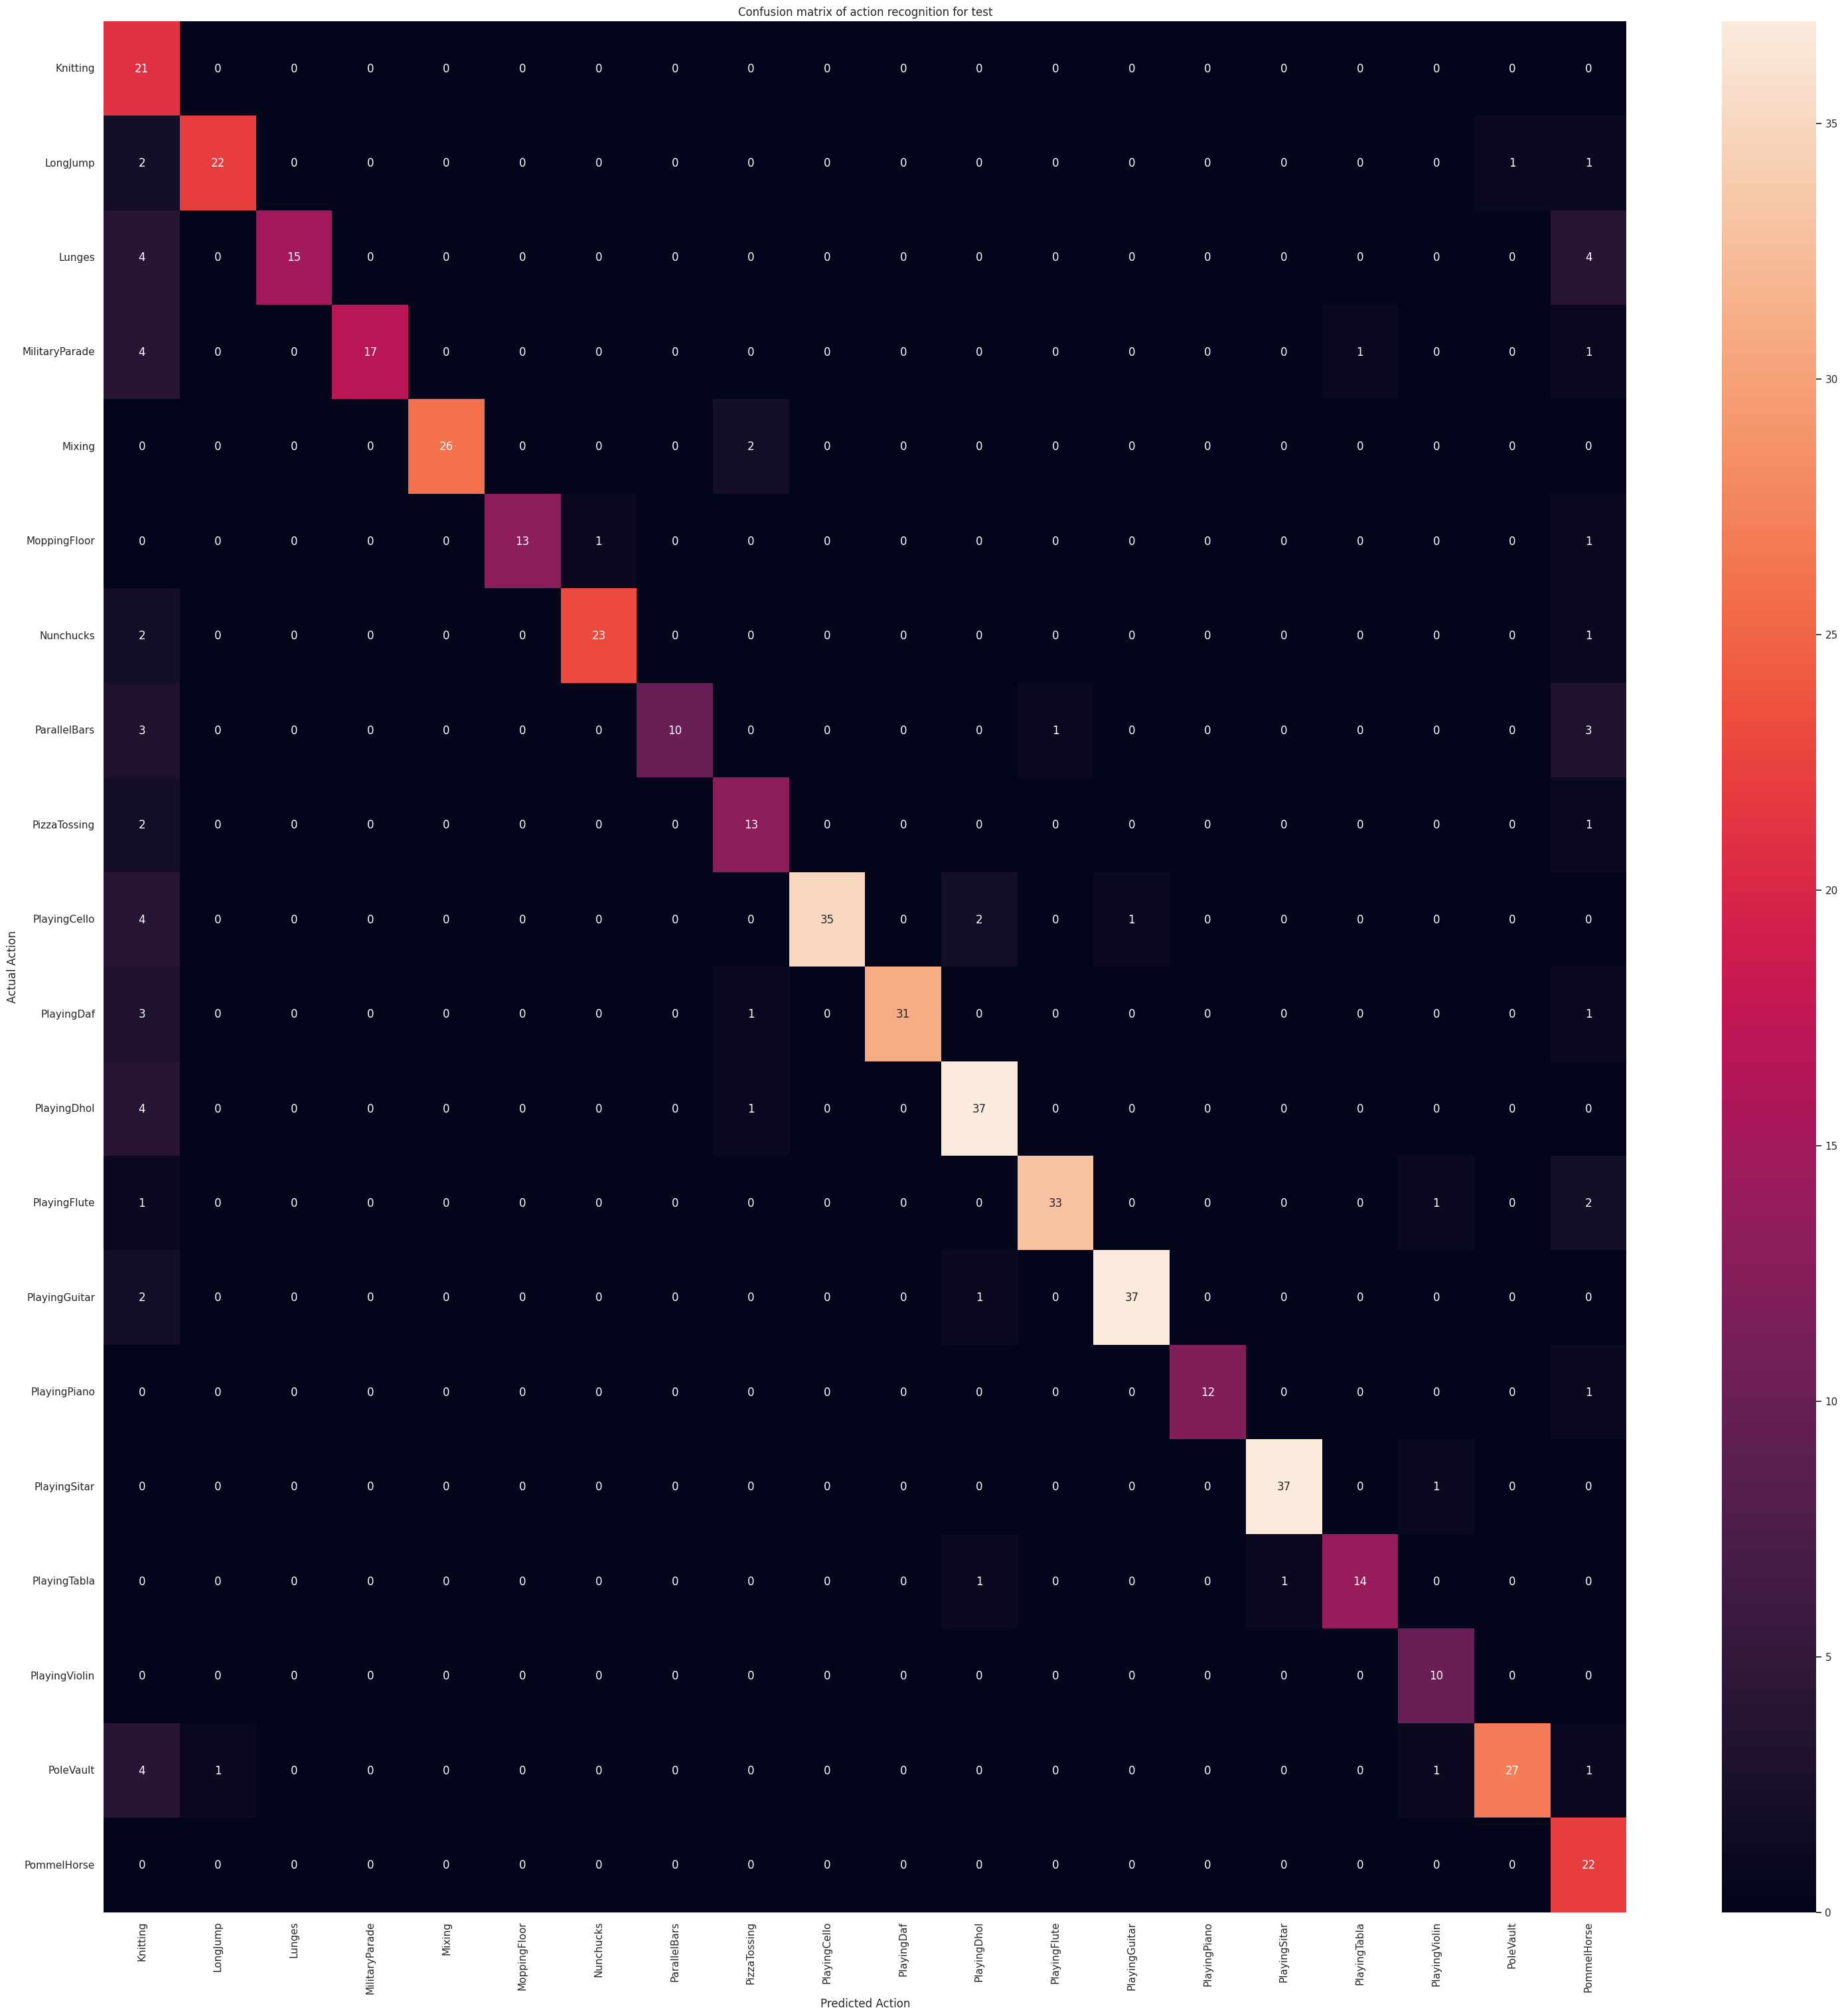

In [54]:
act = actual.numpy()
pred = predicted.numpy()
pred = np.subtract(pred, 49)
pred[pred < 0] = 0
pred[pred > 20] = 19
plot_confusion_matrix(act, pred, label_names_test, 'test')

## Reconstruct the whole model with `use_external_states=True` to make the inference using states.

In [10]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=num_classes,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Load weights from the checkpoint to the rebuilt model
checkpoint_dir = 'trained_model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

## Inference using external states

In [30]:
def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))


BaseballPitch 0.988425
FieldHockeyPenalty 0.005159772
Shotput 0.0025649345
TennisSwing 0.002555242
JavelinThrow 0.00052736735



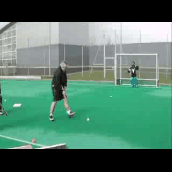

In [31]:
# Create initial states for the stream model
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 172, 172, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in test_ds.take(1):
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    logits, states = model.predict({**states, 'image': clip}, verbose=0)
    all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

## Export to saved model

In [63]:
saved_model_dir = 'model'
tflite_filename = 'tflite_models/model.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


## Convert to TF Lite

In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']


2023-09-12 19:28:42.994435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-12 19:28:42.994930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-12 19:28:43.006924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model
2023-09-12 19:28:43.388912: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-12 19:28:43.388946: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model
2023-09-12 19:28:44.266738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-12 19:28:44.321233: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-12 19:28:45.287561: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model
2023-09-12 19:28:45.723531: I tensorflow

In [12]:
%python .venv/lib/python3.10/site-packages/official/projects/movinet/tools/quantize_movinet.py --saved_model_dir=./model --saved_model_with_states_dir=./model --output_tflite=./tflite_models/model.tflite.int8 --quantization_mode=int8 --

/home/wldnjs/on-device-action-recognition


In [16]:
saved_model_dir = 'model'
tflite_filename = 'tflite_models/model.tflite'
input_shape = [1, 1, 172, 172, 3]

def representative_dataset():
  iterator = iter(val_ds)
  interpreter = tf.lite.Interpreter(model_path=tflite_filename)
  runner = interpreter.get_signature_runner()
  init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
  }
  del init_states['image']
  while True:
    frames, label = next(iterator, (None, None))
    if frames == None:
      break
    
    for clip in frames[0]:
      yield {
        **init_states,
        "image": clip,
      }


converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_int8 = converter.convert()

with open(tflite_filename+".int8", 'wb') as f:
  f.write(tflite_model_int8)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename+".int8")
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']

: 

: 

## Inference using external states on tflite model


BaseballPitch 0.9826083
FieldHockeyPenalty 0.009538501
Shotput 0.0032824264
TennisSwing 0.0029447395
JavelinThrow 0.0009097253



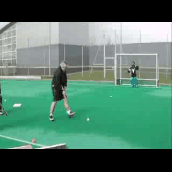

In [34]:
# To run on a video, pass in one frame at a time
states = init_states
for frames, label in test_ds.take(1):
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    outputs = runner(**states, image=clip)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

In [50]:
cpt = sum([len(files) for r, d, files in os.walk("UCF101_subset/test/")])
print(cpt)

2620


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
actual_list = actual.numpy().tolist()
predicted_list = predicted.numpy().tolist()
precision = precision_score(actual_list, predicted_list, average='micro')
recall = recall_score(actual_list, predicted_list, average='micro')
f1 = f1_score(actual_list, predicted_list, average='micro')
acc = accuracy_score(actual_list, predicted_list)
print('Accuracy: ', acc)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)
print(confusion_matrix(actual_list, predicted_list))
print(classification_report(actual_list, predicted_list, digits=3))

Accuracy:  0.849618320610687
Precision:  0.849618320610687
Recall:  0.849618320610687
F1 score:  0.849618320610687
[[29  0  0 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]
 [ 0  0 21 ...  0  0  2]
 ...
 [ 0  0  0 ... 20  1  0]
 [ 0  0  0 ...  0 34  0]
 [ 0  0  0 ...  0  0 17]]
              precision    recall  f1-score   support

           0      0.935     0.879     0.906        33
           1      0.667     0.941     0.780        17
           2      0.955     0.656     0.778        32
           3      0.895     0.654     0.756        26
           4      0.857     0.857     0.857        14
           5      0.941     0.842     0.889        38
           6      0.750     0.857     0.800        35
           7      0.667     0.963     0.788        27
           8      0.962     1.000     0.980        25
           9      0.974     0.950     0.962        40
          10      0.905     0.704     0.792        27
          11      0.897     1.000     0.946        35
          12      0.828   

In [40]:
print(type(actual.numpy().tolist()))
print(type([1,2,3]))

<class 'list'>
<class 'list'>


In [51]:
with open('ucf101_label_map.txt', 'w') as file:
    for label in label_names:
        file.write(label+'\n')